In [49]:
import pandas as pd
import geopandas as gpd
import shapely as sp

# Config

In [50]:
# true leading and trailing edge datasets
lead = pd.read_excel('edge_data_for_christian.xlsx')
trail = pd.read_excel('trailing_edge_data_for_christian.xlsx')

In [51]:
trail['estimated_2019'] = trail.intercept + 2019 * trail.slope
lead['estimated_2019'] = lead.intercept + 2019 * lead.slope

trail = trail.loc[trail.end_year >= 2014].reset_index(drop = True)
lead = lead.loc[lead.end_year >= 2014].reset_index(drop = True)

# obtain all fish scientific names for species we have Aquamaps data for
fishnames = pd.read_csv('species_lists/fish_fullnames.csv')
missing = pd.read_csv('species_lists/missing_species.csv')

missing['sci_name'] = [f"{missing.genus[i]} {missing.species[i]}" for i in range(len(missing))]
fishnames['sci_name'] = [f"{fishnames.genus[i]} {fishnames.species[i]}" for i in range(len(fishnames))]
f = fishnames.loc[~fishnames.sci_name.isin(missing.sci_name)].reset_index(drop = True)

# restrict dataframes trail and head to only include fish listed in f
trail = trail.loc[trail.accepted_name.isin(f.sci_name)].reset_index(drop = True)
lead = lead.loc[lead.accepted_name.isin(f.sci_name)].reset_index(drop = True)

trail['most_recent'] = trail.intercept + trail.end_year * trail.slope
lead['most_recent'] = lead.intercept + lead.end_year * lead.slope

In [52]:
len(lead), len(trail)

(1746, 1720)

In [53]:
for df in [lead, trail]:
    print(f"length: {len(df)}, missing coastal info: {(df.ocean_continent == 'NA-NA').mean()})")

length: 1746, missing coastal info: 0.045819014891179836)
length: 1720, missing coastal info: 0.04825581395348837)


In [54]:
lead = lead.loc[lead.ocean_continent != 'NA-NA'].reset_index(drop = True)
trail = trail.loc[trail.ocean_continent != 'NA-NA'].reset_index(drop = True)

In [55]:
lead.head()

,accepted_name,ocean_continent,survey,season,start_year,end_year,edge,slope,intercept,estimated_2019,most_recent
0,Acantholabrus palloni,Atlantic Ocean-Europe,PT-IBTS,NaN,2005,2017,Leading Edge,0.009666,21.856607,41.371393,41.352062
1,Aetobatus narinari,Atlantic Ocean-North America,SEUS,FALL,1998,2018,Leading Edge,0.030151,-28.391677,32.483915,32.453764
2,Agonus cataphractus,Atlantic Ocean-Europe,BITS,NaN,1999,2020,Leading Edge,0.001674,53.870487,57.251258,57.252932
3,Agonus cataphractus,Atlantic Ocean-Europe,FR-CGFS,NaN,1998,2020,Leading Edge,0.002496,45.939992,50.980357,50.982853
4,Agonus cataphractus,Atlantic Ocean-Europe,IE-IGFS,NaN,2003,2019,Leading Edge,0.042313,-29.421084,56.009502,56.009502


In [56]:
# only keep the highest predicted latitude on a given coast for the leaders
grouped_lead = lead.groupby(by = ['accepted_name', 'ocean_continent']).estimated_2019.max()

# only keep lowest predicted latitude on a given coast for the trailers
grouped_trail = trail.groupby(by = ['accepted_name', 'ocean_continent']).estimated_2019.min()

In [57]:
keep = []
for i in range(len(lead)):
    name = lead.accepted_name.loc[i]
    coast = lead.ocean_continent.loc[i]
    if lead.estimated_2019.loc[i] == grouped_lead.loc[(name, coast)]:
        keep.append(i)
lead = lead.loc[keep].reset_index(drop = True)

In [58]:
keep = []
for i in range(len(trail)):
    name = trail.accepted_name.loc[i]
    coast = trail.ocean_continent.loc[i]
    if trail.estimated_2019.loc[i] == grouped_trail.loc[(name, coast)]:
        keep.append(i)
trail = trail.loc[keep].reset_index(drop = True)

# Preparing shape file

In [59]:
gdf = gpd.read_file('/Users/jameswagner/Dropbox/Mac/Desktop/Fish Ranges/MEOW/meow_ecos.shp')

In [60]:
gdf.columns

Index(['ECO_CODE', 'ECOREGION', 'PROV_CODE', 'PROVINCE', 'RLM_CODE', 'REALM',
       'ALT_CODE', 'ECO_CODE_X', 'Lat_Zone', 'geometry'],
      dtype='object')

In [61]:
gdf.ECOREGION.loc[gdf.ECO_CODE_X == 169]

46    Cocos Islands
Name: ECOREGION, dtype: object

In [62]:
# defining north-american ecoregion id's in an np array
atlantic_namer = [63, 42, 62, 38, 39, 40, 41, 42, 5, 6, 7]
# gulf of mexico: 69, 43, 70
# caribbearn: 67, 68, 65, 64

atlantic_euro = [27, 26, 25, 24, 21, 22, 23]
# iceland: 20, 2
# mediterranean: 30, 31, 32, 33, 34, 35, 36


pacific_namer = [170, 168, 167, 166, 164,
                60, 61, 59, 58, 57, 56, 55, 54]
# Clipperton: 165
# Cocos Islands: 169
# Aleutian Islands: 53
# bearing sea: 14

In [63]:
gdf.loc[gdf.ECO_CODE_X == 29]

,ECO_CODE,ECOREGION,PROV_CODE,PROVINCE,RLM_CODE,REALM,ALT_CODE,ECO_CODE_X,Lat_Zone,geometry
13,20029.0,Azores Canaries Madeira,3.0,Lusitanian,2.0,Temperate Northern Atlantic,36.0,29.0,Temperate,"MULTIPOLYGON (((-16.39408 26.37686, -19.20883 ..."


In [64]:
gdf.columns

Index(['ECO_CODE', 'ECOREGION', 'PROV_CODE', 'PROVINCE', 'RLM_CODE', 'REALM',
       'ALT_CODE', 'ECO_CODE_X', 'Lat_Zone', 'geometry'],
      dtype='object')

In [65]:
coast_labels = [None] * len(gdf)
ecoregions = ['atl_euro', 'atl_namer', 'pac_namer']
for i,code in enumerate(gdf.ECO_CODE_X):
    if code in atlantic_namer:
        coast_labels[i] = ecoregions[1]
    elif code in pacific_namer:
        coast_labels[i] = ecoregions[2]
    elif code in atlantic_euro:
        coast_labels[i] = ecoregions[0]

In [66]:
gdf['coast'] = coast_labels

In [67]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [68]:
coastal_gdf = gdf.groupby('coast')
coast_geoms = coastal_gdf['geometry'].apply(sp.unary_union)
coast_gdf = gpd.GeoDataFrame(geometry=coast_geoms, crs=gdf.crs)

In [69]:
coast_gdf.loc['atl_euro']

geometry    POLYGON ((-11.89763 35.42278, -11.95614 35.546...
Name: atl_euro, dtype: geometry

<Axes: >

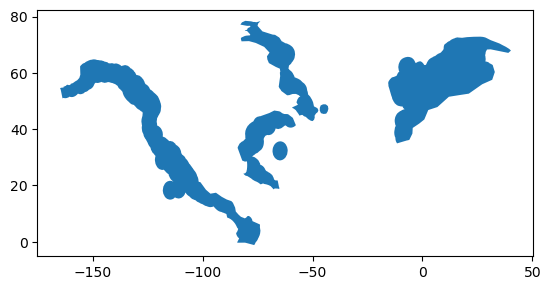

In [70]:
coast_gdf.plot()

# Prepare ECDF's for each coast in question

In [71]:
#Atlantic Europe, Atlantic North America, Pacific North America
ECDF = [{},{},{}]
HD_ECDF = [{},{},{}]

In [72]:
prob_cutoff = 0.80

In [73]:
ecoregions

['atl_euro', 'atl_namer', 'pac_namer']

In [74]:
for i in range(len(f)):
    g = f.genus.loc[i].lower()
    s = f.species.loc[i].lower()
    filepath = f'fish_data/{g}_{s}.csv'
    full_map = pd.read_csv(filepath)

    # subdivide into each of the three coastal regional maps
    points = [sp.Point(lat, lon) for lon,lat in zip(full_map['Center Lat'], full_map['Center Long'])]
    maps = []
    for ecoreg in ecoregions:
        maps.append(full_map.loc[coast_gdf.loc[ecoreg].geometry.contains(points)])
        # fills the maps in the following order: Atlantic Europe, Atlantic North America, Pacific North America

    # calculate north-south ecdfs for each map
    for j,map in enumerate(maps):
        net_density = map.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
        net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
        net_density['ECDF'] = net_density['PMF'].cumsum()

        ECDF[j][f.sci_name.loc[i]] = net_density[['Center Lat', 'ECDF']]
        ECDF[j][f.sci_name.loc[i]].columns = ['latitude', 'ecdf']


    
    # repeat for only cells with probability higher than the specified prob_cutoff
    hd_maps = []
    for map in maps:
        hd_maps.append(map.loc[map['Overall Probability'] >= prob_cutoff].reset_index(drop=True))

    # calculate north-south ecdfs for each map
    for j,map in enumerate(hd_maps):
        net_density = map.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
        net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
        net_density['ECDF'] = net_density['PMF'].cumsum()

        HD_ECDF[j][f.sci_name.loc[i]] = net_density[['Center Lat', 'ECDF']]
        HD_ECDF[j][f.sci_name.loc[i]].columns = ['latitude', 'ecdf']

# Find coast-specific percentiles

In [75]:
ocean_continents = {'Atlantic Ocean-North America': 1, 'Atlantic Ocean-Europe': 0, 'Pacific Ocean-North America': 2}

In [76]:
def find_percentiles(lat, species_name, coast):
    # lat is in degrees north
    # species name is capital Genus lowercase species
    # coast is an integer 0-2
    raw_density = ECDF[coast][species_name]
    HD_density = HD_ECDF[coast][species_name]
    
    # first get the raw percentiles
    max_lat = raw_density.latitude.loc[raw_density.latitude <= lat].max()
    raw_percentile = raw_density.ecdf.loc[raw_density.latitude == max_lat].max()

    # now get the high density (prob >= 80%) percentiles
    hd_max_lat = HD_density.latitude.loc[HD_density.latitude <= lat].max()
    hd_percentile = HD_density.ecdf.loc[HD_density.latitude == hd_max_lat].max()

    return raw_percentile, hd_percentile

In [77]:
def percentile_of_calculated_edge(edge_col, name_col, region_col, edge_df):
    # edge_col is the string form of the column label which contains a float latitude in degrees north
    # name_col is the string form of the column label which contains the string species name
    # region_col is the string column label which contains the continent region
    # edge_df is a dataframe of calculated range edges
    raws = []
    hds = []

    for name,edge,coast in zip(edge_df[name_col], edge_df[edge_col], edge_df[region_col]):
        coastal_region = ocean_continents[coast]
        r,h = find_percentiles(edge, name, coastal_region)
        raws.append(r)
        hds.append(h)

    return [raws, hds]

In [78]:
trail_percentiles = percentile_of_calculated_edge('estimated_2019', 'accepted_name', 'ocean_continent', trail)
lead_percentiles = percentile_of_calculated_edge('estimated_2019', 'accepted_name', 'ocean_continent', lead)

In [79]:
trail['raw_percentile'] = trail_percentiles[0]
trail['hd_percentile'] = trail_percentiles[1]

In [80]:
lead['raw_percentile'] = lead_percentiles[0]
lead['hd_percentile'] = lead_percentiles[1]

# Verification

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

(array([ 16.,  14.,  26.,  28.,  36.,  50.,  67.,  53.,  87., 290.]),
 array([0.02357934, 0.12122141, 0.21886348, 0.31650554, 0.41414761,
        0.51178967, 0.60943174, 0.7070738 , 0.80471587, 0.90235793,
        1.        ]),
 <BarContainer object of 10 artists>)

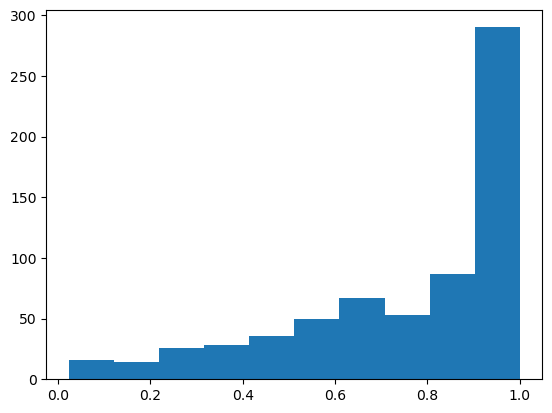

In [82]:
plt.hist(lead.hd_percentile)

(array([159., 109.,  80.,  50.,  33.,  30.,  16.,  17.,  14.,  24.]),
 array([9.30773706e-04, 1.00837696e-01, 2.00744619e-01, 3.00651542e-01,
        4.00558464e-01, 5.00465387e-01, 6.00372309e-01, 7.00279232e-01,
        8.00186155e-01, 9.00093077e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

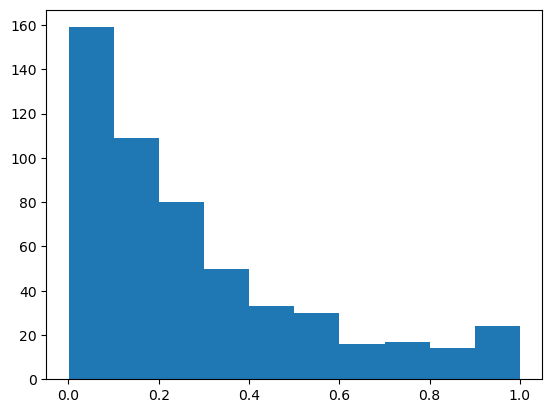

In [83]:
plt.hist(trail.hd_percentile)

(array([ 13.,  18.,  17.,  36.,  37.,  55.,  87.,  78.,  95., 237.]),
 array([0.01629519, 0.11466567, 0.21303615, 0.31140663, 0.40977711,
        0.50814759, 0.60651807, 0.70488856, 0.80325904, 0.90162952,
        1.        ]),
 <BarContainer object of 10 artists>)

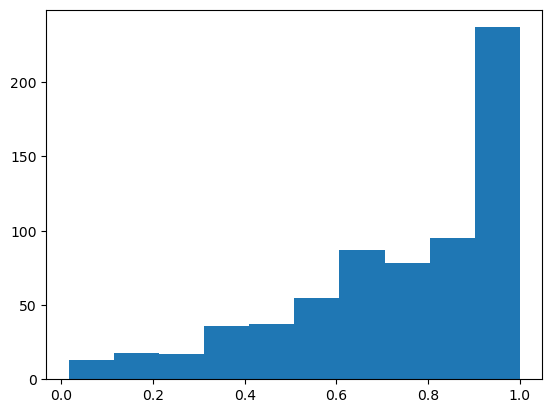

In [84]:
plt.hist(lead.raw_percentile)

(array([180.,  96.,  79.,  85.,  67.,  32.,  27.,  17.,  17.,  26.]),
 array([1.92270717e-04, 1.00173044e-01, 2.00153817e-01, 3.00134590e-01,
        4.00115362e-01, 5.00096135e-01, 6.00076908e-01, 7.00057681e-01,
        8.00038454e-01, 9.00019227e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

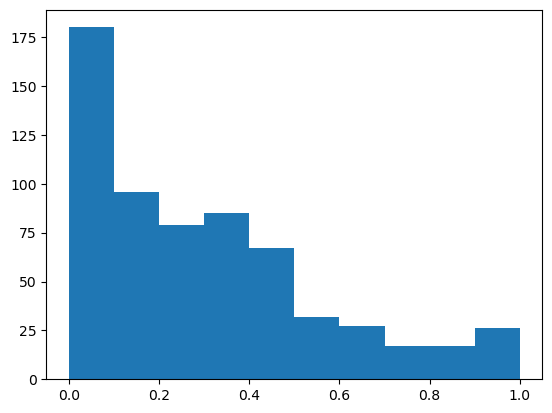

In [85]:
plt.hist(trail.raw_percentile)

In [91]:
import arviz as az
import numpy as np

In [103]:
az.hdi(np.array(lead.raw_percentile.dropna()), 0.60).round(2), az.hdi(np.array(trail.raw_percentile.dropna()), 0.60).round(2)

(array([0.71, 1.  ]), array([0.  , 0.32]))

In [104]:
az.hdi(np.array(lead.hd_percentile.dropna()), 0.60).round(2), az.hdi(np.array(trail.hd_percentile.dropna()), 0.60).round(2)

(array([0.75, 1.  ]), array([0.  , 0.26]))